In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


In [37]:
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cur = con.cursor()

Q: How are tmdb ratings linked to revenue and profitability? (simplified)

In [39]:
#simplified
query1="""select title, popularity, vote_average, vote_count 
production_budget, domestic_gross, worldwide_gross
from tmdb_movies join tn_movie_budgets on title=movie"""
#cur.execute(query,con)
#df=pd.DataFrame(cur.fetchall())
#df.columns = [x[0] for x in cur.description()]
#df
df1 = pd.read_sql_query(query1, con)
df1.head()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2448 non-null   object 
 1   popularity         2448 non-null   float64
 2   vote_average       2448 non-null   float64
 3   production_budget  2448 non-null   int64  
 4   domestic_gross     2448 non-null   object 
 5   worldwide_gross    2448 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 114.9+ KB


In [8]:
df1[df1.columns[3:]] = df1[df1.columns[3:]].replace('[\$,]', '', regex=True).astype(float)

In [9]:
df1['profitability'] = df1['worldwide_gross']-df1['production_budget']

In [10]:
df1.sort_values(by=['profitability'],ascending=False)

,title,popularity,vote_average,production_budget,domestic_gross,worldwide_gross,profitability
5,Avatar,26.526,7.4,18676.0,760507625.0,2.776345e+09,2.776327e+09
2240,Avengers: Infinity War,80.773,8.3,13948.0,678815482.0,2.048134e+09,2.048120e+09
1430,Jurassic World,20.709,6.6,14056.0,652270625.0,1.648855e+09,1.648841e+09
1433,Furious 7,20.396,7.3,6538.0,353007020.0,1.518723e+09,1.518716e+09
581,The Avengers,50.289,7.6,19673.0,623279547.0,1.517936e+09,1.517916e+09
...,...,...,...,...,...,...,...
1810,Hush,12.194,6.8,2147.0,0.0,0.000000e+00,-2.147000e+03
1487,Home,12.835,6.8,2372.0,0.0,0.000000e+00,-2.372000e+03
2071,Bright,15.677,6.2,3181.0,0.0,0.000000e+00,-3.181000e+03
2281,Bird Box,26.156,7.0,4777.0,0.0,0.000000e+00,-4.777000e+03


Text(0, 0.5, 'profitability')

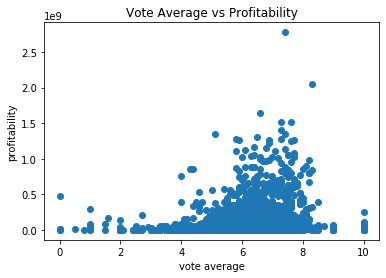

In [15]:
plt.scatter(df1['vote_average'],df1['profitability'])
plt.title('Vote Average vs Profitability')
plt.xlabel('vote average')
plt.ylabel('profitability')

Q2: Is there a better way to incorporate both tables of revenue to see a better trend?
TMDB has the most cells - left joining here should allow for full representation of both revenue tables. This did not end up being the case, as evidenced by the length

In [25]:
join_tmdb_rev_tables_query = """SELECT DISTINCT
    t.id as tmdb_id,
    t.title,
    year,
    popularity,
    vote_average,
    vote_count production_budget,
    tn.domestic_gross as tn_domestic_gross,
    tn.worldwide_gross as tn_worldwide_gross,
    b.domestic_gross as bom_domestic_gross,
    b.foreign_gross as bom_foreign_gross
FROM
    tmdb_movies t
        LEFT JOIN
    tn_movie_budgets tn ON title = movie
        LEFT JOIN
    bom_movie_gross b USING (title)
WHERE
    (tn.domestic_gross IS NOT NULL
        OR tn.worldwide_gross IS NOT NULL
        OR b.domestic_gross IS NOT NULL
        OR b.foreign_gross IS NOT NULL)
"""
df_tmdb_rev =  pd.read_sql_query(join_tmdb_rev_tables_query, con)
df_tmdb_rev[df_tmdb_rev.columns[6:8]] = df_tmdb_rev[df_tmdb_rev.columns[6:8]].replace('[\$,]', '', regex=True).astype(float)

In [26]:
df_tmdb_rev.head()

,tmdb_id,title,year,popularity,vote_average,production_budget,tn_domestic_gross,tn_worldwide_gross,bom_domestic_gross,bom_foreign_gross
0,10193,Toy Story 3,2010.0,24.445,7.7,8340,415004880.0,1.068880e+09,415000000.0,652000000.0
1,27205,Inception,2010.0,27.920,8.3,22186,292576195.0,8.355246e+08,292600000.0,535700000.0
2,10192,Shrek Forever After,2010.0,15.041,6.1,3843,238736787.0,7.562447e+08,238700000.0,513900000.0
3,24021,The Twilight Saga: Eclipse,2010.0,20.340,6.0,4909,300531751.0,7.061028e+08,300500000.0,398000000.0
4,10138,Iron Man 2,2010.0,28.515,6.8,12368,312433331.0,6.211564e+08,312400000.0,311500000.0


In [7]:
df_tmdb_rev.to_csv('tmdb_combined_movie_revenue')

In [8]:
df_tmdb_rev.shape

(3498, 10)

Q3: how can i outer join the revenue tables to have a full picture of revenue

In [38]:
query2 = """SELECT 
    CASE
        WHEN title IS NULL THEN movie
        ELSE title
    END AS movie_title,
    release_date,
    year,
    production_budget,
    CASE
        WHEN title IS NULL THEN tmdb_domestic_gross
        ELSE bom_domestic_gross
    END AS domestic_gross,
    CASE
        WHEN title IS NULL THEN tmdb_worldwide_gross
        ELSE bom_domestic_gross + bom_foreign_gross
    END AS worldwide_gross
FROM
    (SELECT DISTINCT
        title,
            movie,
            CASE
                WHEN b.domestic_gross IS NULL THEN 0
                ELSE b.domestic_gross
            END AS bom_domestic_gross,
            CASE
                WHEN b.foreign_gross IS NULL THEN 0
                ELSE b.foreign_gross
            END AS bom_foreign_gross,
            release_date,
            year,
            production_budget,
            t.domestic_gross AS tmdb_domestic_gross,
            t.worldwide_gross AS tmdb_worldwide_gross
    FROM
        bom_movie_gross b
    LEFT JOIN tn_movie_budgets t ON movie = title
    WHERE
        b.domestic_gross IS NOT NULL
            OR b.foreign_gross IS NOT NULL
            OR t.domestic_gross IS NOT NULL
            OR t.worldwide_gross IS NOT NULL UNION SELECT DISTINCT
        title,
            movie,
            CASE
                WHEN b.domestic_gross IS NULL THEN 0
                ELSE b.domestic_gross
            END AS bom_domestic_gross,
            CASE
                WHEN b.foreign_gross IS NULL THEN 0
                ELSE b.foreign_gross
            END AS bom_foreign_gross,
            release_date,
            year,
            production_budget,
            t.domestic_gross AS tmdb_domestic_gross,
            t.worldwide_gross AS tmdb_worldwide_gross
    FROM
        bom_movie_gross b
    RIGHT JOIN tn_movie_budgets t ON movie = title
    WHERE
        b.domestic_gross IS NOT NULL
            OR b.foreign_gross IS NOT NULL
            OR t.domestic_gross IS NOT NULL
            OR t.worldwide_gross IS NOT NULL
    ORDER BY bom_domestic_gross) a
"""
df_joint_rev =  pd.read_sql_query(query2, con)

In [39]:
df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,Friday the 13th Part 2,"Apr 30, 1981",NaN,"$1,250,000","$21,722,776","$21,722,776"
1,Punch-Drunk Love,"Oct 11, 2002",NaN,"$25,000,000","$17,791,031","$24,591,031"
2,Catch-22,"Jun 24, 1970",NaN,"$18,000,000","$24,911,670","$24,911,670"
3,Stardust,"Aug 10, 2007",NaN,"$70,000,000","$38,634,938","$137,022,245"
4,Notting Hill,"May 28, 1999",NaN,"$42,000,000","$116,089,678","$363,728,085"


In [40]:
df_joint_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7891 entries, 0 to 7890
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        7891 non-null   object 
 1   release_date       5782 non-null   object 
 2   year               3396 non-null   float64
 3   production_budget  5782 non-null   object 
 4   domestic_gross     7891 non-null   object 
 5   worldwide_gross    7891 non-null   object 
dtypes: float64(1), object(5)
memory usage: 370.0+ KB


In [41]:
df_joint_rev[df_joint_rev.columns[3:]] = df_joint_rev[df_joint_rev.columns[3:]].replace('[\$,]', '', regex=True).astype(float)
df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,Friday the 13th Part 2,"Apr 30, 1981",NaN,1250000.0,21722776.0,21722776.0
1,Punch-Drunk Love,"Oct 11, 2002",NaN,25000000.0,17791031.0,24591031.0
2,Catch-22,"Jun 24, 1970",NaN,18000000.0,24911670.0,24911670.0
3,Stardust,"Aug 10, 2007",NaN,70000000.0,38634938.0,137022245.0
4,Notting Hill,"May 28, 1999",NaN,42000000.0,116089678.0,363728085.0


In [42]:
df_joint_rev.to_csv('joined_revenue')

In [43]:
df_joint_rev=pd.read_csv('joined_revenue')